In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Flatten

In [12]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
train = pd.read_csv('/kaggle/input/air-quality-forcasting-data/train.csv')
test = pd.read_csv('/kaggle/input/air-quality-forcasting-data/test.csv')

In [14]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print("Training Data Overview:")
print(train.head())
print("\nTest Data Overview:")
print(test.head())

Training Data Overview:
                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   

                           Ir   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
datetime                                                            
2010-01-01 00:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 01:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 02:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 03:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 04:00:00 -0

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## **Explore Training Data**

Training Data Statistics:
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      

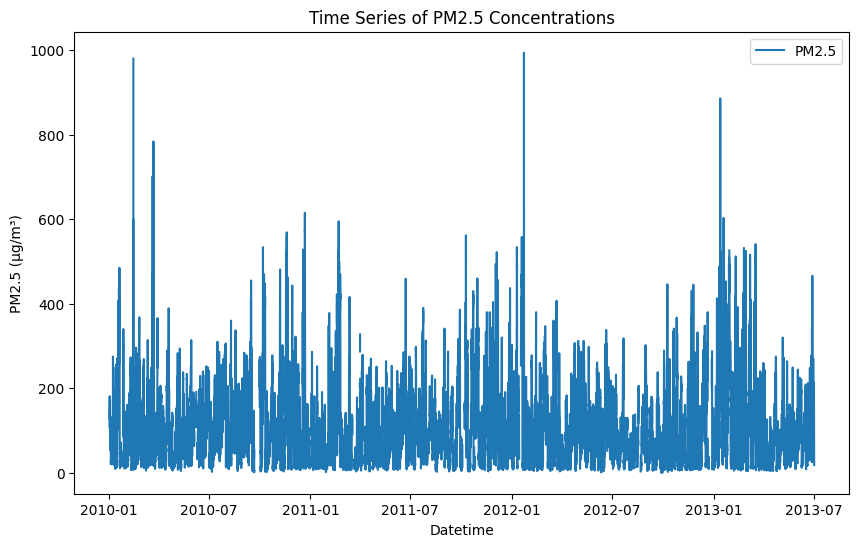

Periodic spikes suggest seasonal patterns.


<Figure size 1200x800 with 0 Axes>

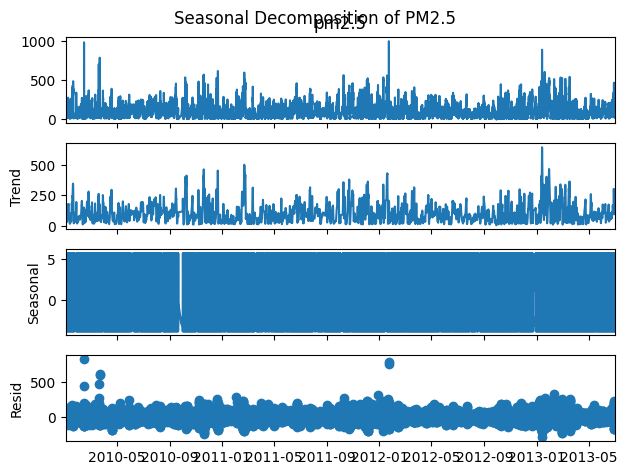

Daily seasonality supports 24-hour sequences.


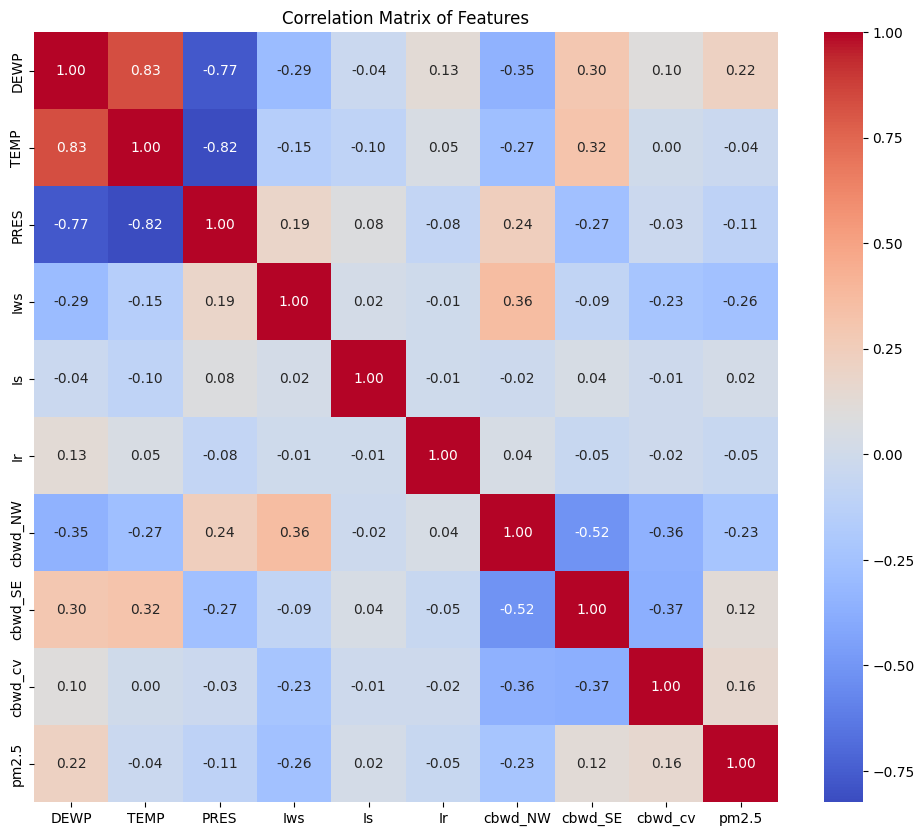

Weak PM2.5 correlations emphasize temporal features.


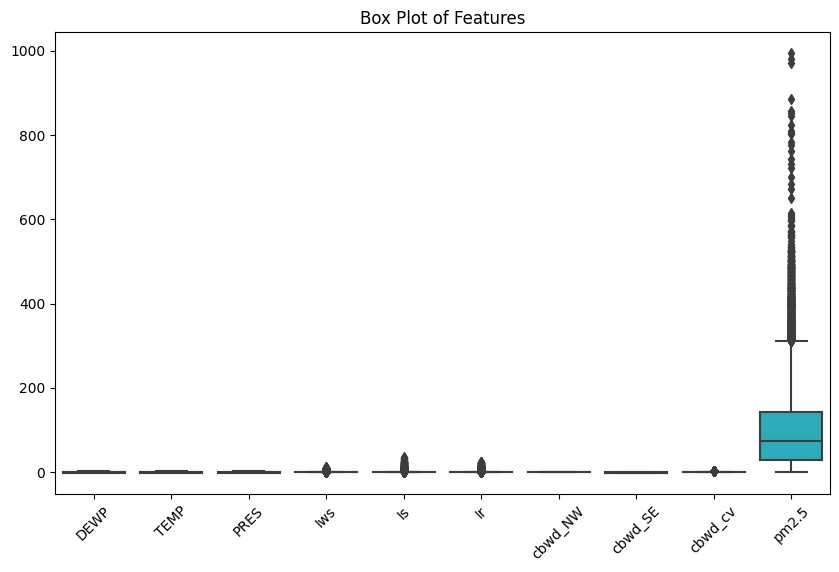

Outliers detected in box plot, suggesting robust preprocessing.


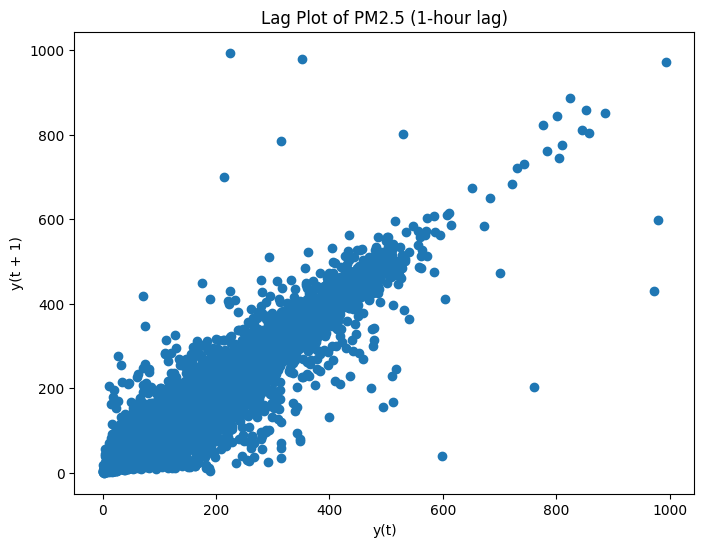

Strong autocorrelation supports lagged PM2.5 features.


In [15]:
print("Training Data Statistics:")
print(train.describe())

print("\nMissing Values in Training Data:")
print(train.isnull().sum())

# Time series plot
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()
print("Periodic spikes suggest seasonal patterns.")

# Seasonal decomposition
decomposition = seasonal_decompose(train['pm2.5'].dropna(), model='additive', period=24)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of PM2.5')
plt.show()
print("Daily seasonality supports 24-hour sequences.")

# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = train.select_dtypes(include=['float64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()
print("Weak PM2.5 correlations emphasize temporal features.")

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.drop(['No'], axis=1))
plt.title('Box Plot of Features')
plt.xticks(rotation=45)
plt.show()
print("Outliers detected in box plot, suggesting robust preprocessing.")

# Lag plot
plt.figure(figsize=(8, 6))
pd.plotting.lag_plot(train['pm2.5'].dropna(), lag=1)
plt.title('Lag Plot of PM2.5 (1-hour lag)')
plt.show()
print("Strong autocorrelation supports lagged PM2.5 features.")

## **Explore Test Data**

In [16]:
print("\nTest Data Statistics:")
print(test.describe())

print("\nMissing Values in Test Data:")
print(test.isnull().sum())


Test Data Statistics:
                 No          DEWP          TEMP          PRES           Iws  \
count  13148.000000  13148.000000  13148.000000  13148.000000  13148.000000   
mean   37250.500000      0.068667      0.146315     -0.031759     -0.071257   
std     3795.645004      1.010409      0.947697      0.978042      0.952125   
min    30677.000000     -2.897280     -2.086205     -2.478206     -0.468688   
25%    33963.750000     -0.749466     -0.692588     -0.920055     -0.441894   
50%    37250.500000      0.220515      0.209164     -0.043595     -0.388505   
75%    40537.250000      0.982643      0.946961      0.735481     -0.137955   
max    43824.000000      1.675486      2.422555      2.196248      9.327940   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  
count  13148.000000  13148.000000  13148.000000  13148.000000  13148.000000  
mean      -0.039645     -0.026255     -0.037780     -0.013608      0.058346  
std        0.756872      0.8318

## **Feature Engineering and Preprocessing**

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def create_features(df, target_available=True, pm25_mean_values=None):
    """
    Create time-based and lagged features for time-series forecasting.
    Args:
        df: DataFrame with datetime index
        target_available: Boolean indicating if 'pm2.5' is present (True for train, False for test)
        pm25_mean_values: Dict with mean values for pm2.5-based features (for test data)
    Returns:
        DataFrame with new features
    """
    df = df.copy()
    # Time-based features
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # Cyclical encoding
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lagged features for weather variables
    df['DEWP_lag1'] = df['DEWP'].shift(1)
    df['TEMP_lag1'] = df['TEMP'].shift(1)
    df['Iws_lag1'] = df['Iws'].shift(1)
    
    # PM2.5-based features
    if target_available:
        df['pm2.5_lag1'] = df['pm2.5'].shift(1)
        df['pm2.5_lag24'] = df['pm2.5'].shift(24)
        df['pm2.5_roll_mean'] = df['pm2.5'].rolling(window=24).mean()
    else:
        # Initialize with mean values from training data
        if pm25_mean_values is not None:
            df['pm2.5_lag1'] = pm25_mean_values['pm2.5_lag1']
            df['pm2.5_lag24'] = pm25_mean_values['pm2.5_lag24']
            df['pm2.5_roll_mean'] = pm25_mean_values['pm2.5_roll_mean']
        else:
            df['pm2.5_lag1'] = 0
            df['pm2.5_lag24'] = 0
            df['pm2.5_roll_mean'] = 0
    
    return df

# Apply feature engineering to training data
train = create_features(train, target_available=True)

# Compute mean values for PM2.5-based features from training data
pm25_mean_values = {
    'pm2.5_lag1': train['pm2.5_lag1'].mean(),
    'pm2.5_lag24': train['pm2.5_lag24'].mean(),
    'pm2.5_roll_mean': train['pm2.5_roll_mean'].mean()
}

# Apply feature engineering to test data with mean PM2.5 values
test = create_features(test, target_available=False, pm25_mean_values=pm25_mean_values)

# Handle missing values
train['pm2.5'] = train['pm2.5'].interpolate(method='linear')
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Define features (including PM2.5-based features)
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
            'hour', 'month', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
            'DEWP_lag1', 'TEMP_lag1', 'Iws_lag1', 'pm2.5_lag1', 'pm2.5_lag24', 'pm2.5_roll_mean']

X_train = train[features]
y_train = train['pm2.5']
X_test = test[features]

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create sequences
def create_sequences(X, y=None, time_steps=24):
    """
    Create sequences for LSTM input.
    Args:
        X: Feature array
        y: Target array (None for test)
        time_steps: Number of timesteps
    Returns:
        Sequences (Xs, ys) or Xs
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        if y is not None:
            ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys) if y is not None else np.array(Xs)

time_steps = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq = create_sequences(X_test_scaled, None, time_steps)[0]

# Split training data
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=42)

print(f"Training Sequences Shape: {X_train_seq.shape}")
print(f"Validation Sequences Shape: {X_val_seq.shape}")
print(f"Test Sequences Shape: {X_test_seq.shape}")

/tmp/ipykernel_35/4286282936.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i + time_steps])


Training Sequences Shape: (24521, 24, 21)
Validation Sequences Shape: (6131, 24, 21)
Test Sequences Shape: (13124, 24, 21)


## **Define and Run Experiments**


Running Experiment 1: {'layers': 2, 'units': [128, 64], 'lr': 0.01, 'batch_size': 32, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.2}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


2025-05-27 09:05:19.346569: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


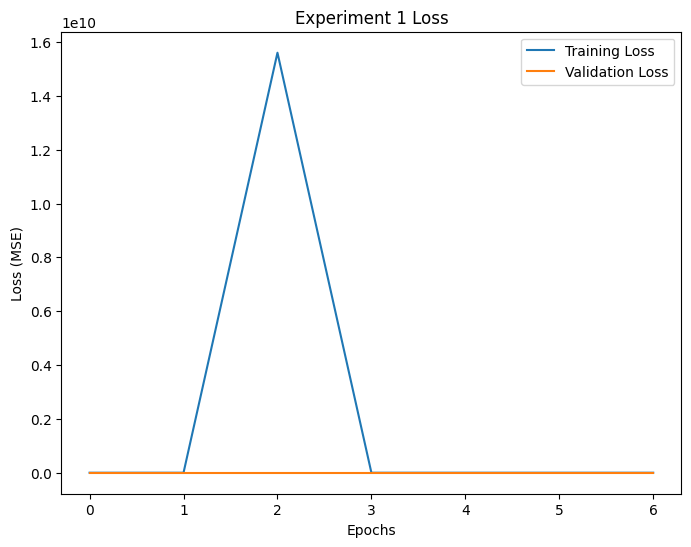


Running Experiment 2: {'layers': 2, 'units': [64, 32], 'lr': 0.001, 'batch_size': 64, 'optimizer': 'RMSprop', 'time_steps': 24, 'dropout': 0.3}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


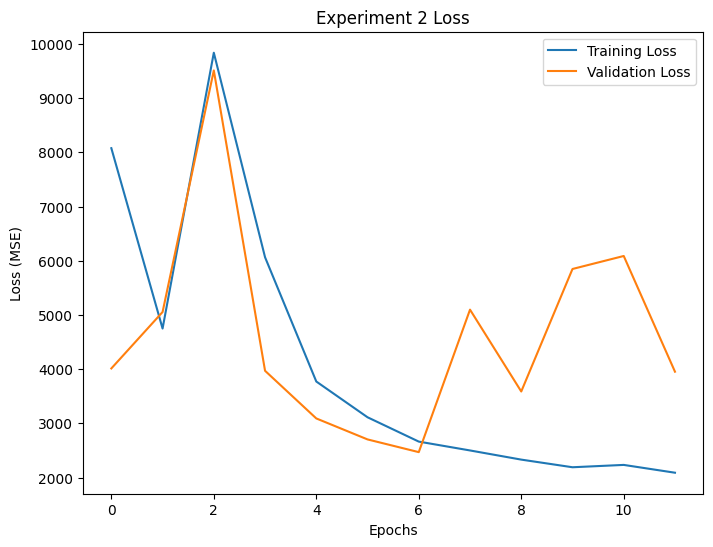


Running Experiment 3: {'layers': 3, 'units': [128, 64, 32], 'lr': 0.005, 'batch_size': 32, 'optimizer': 'Adam', 'time_steps': 12, 'dropout': 0.2}
X_train_seq_exp shape: (24531, 12, 21)
y_train_seq_exp shape: (24531,)
X_val_seq_exp shape: (6133, 12, 21)
y_val_seq_exp shape: (6133,)


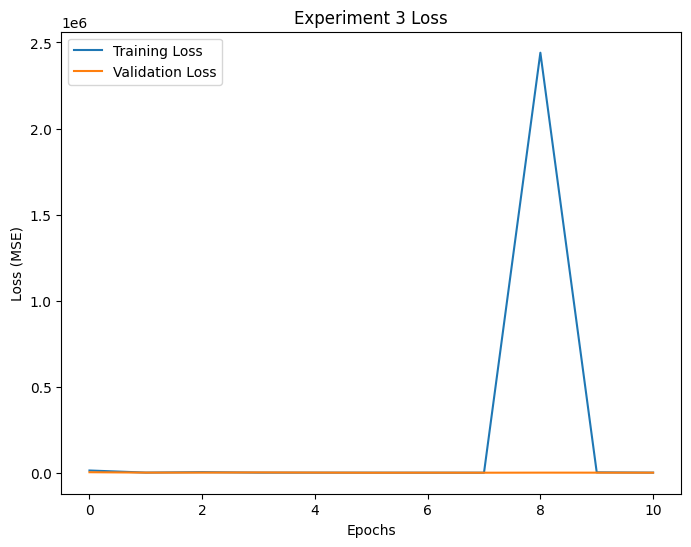


Running Experiment 4: {'layers': 2, 'units': [256, 128], 'lr': 0.01, 'batch_size': 16, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.4}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


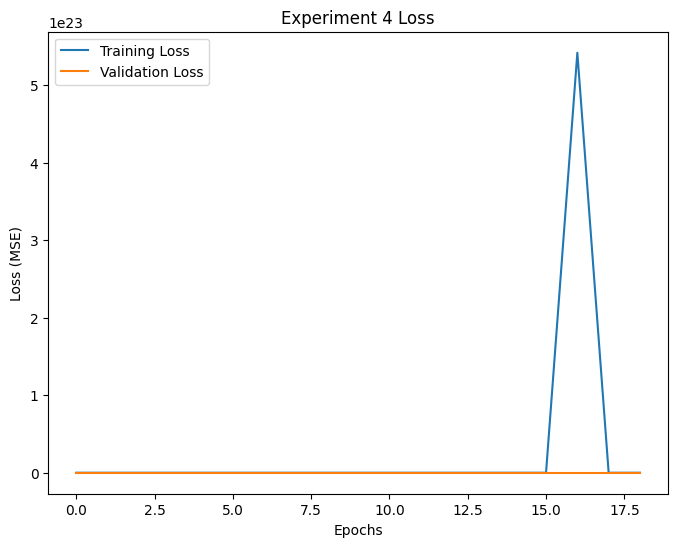


Running Experiment 5: {'layers': 2, 'units': [64, 64], 'lr': 0.001, 'batch_size': 32, 'optimizer': 'RMSprop', 'time_steps': 48, 'dropout': 0.2}
X_train_seq_exp shape: (24502, 48, 21)
y_train_seq_exp shape: (24502,)
X_val_seq_exp shape: (6126, 48, 21)
y_val_seq_exp shape: (6126,)


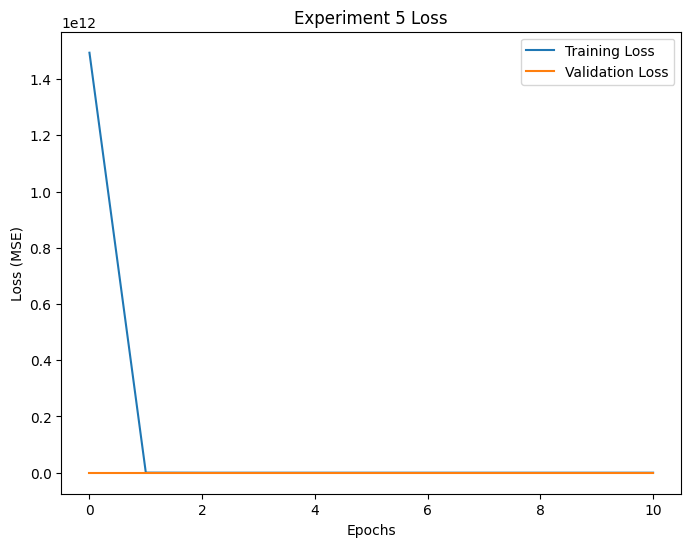


Running Experiment 6: {'layers': 3, 'units': [128, 64, 32], 'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.3}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


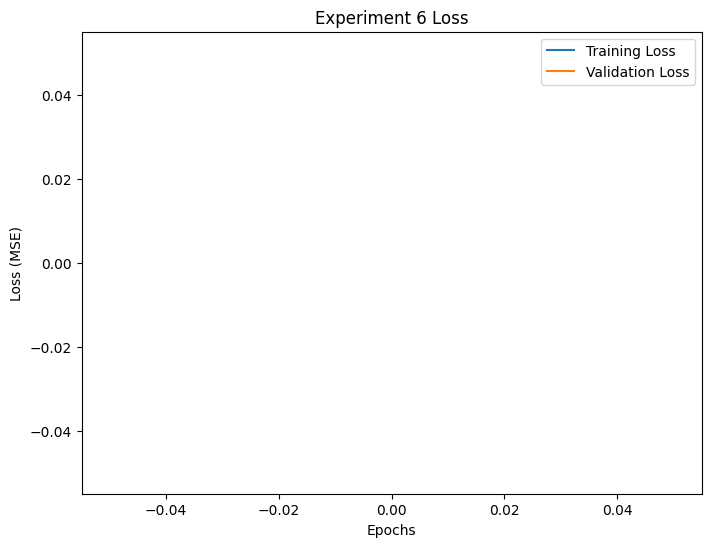


Running Experiment 7: {'layers': 2, 'units': [128, 64], 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.2}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


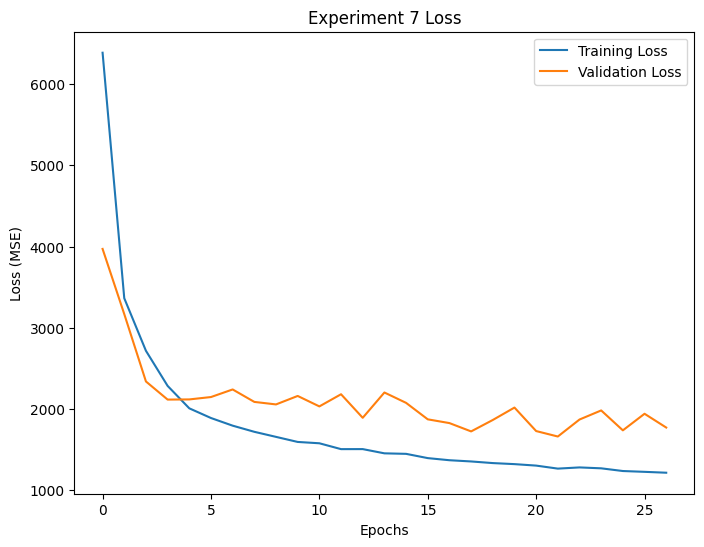


Running Experiment 8: {'layers': 2, 'units': [64, 32], 'lr': 0.005, 'batch_size': 16, 'optimizer': 'RMSprop', 'time_steps': 24, 'dropout': 0.3}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


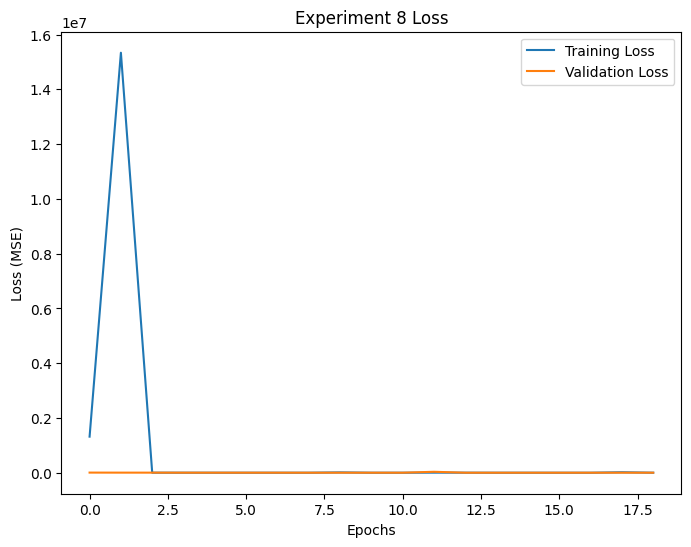


Running Experiment 9: {'layers': 2, 'units': [128, 64], 'lr': 0.01, 'batch_size': 32, 'optimizer': 'RMSprop', 'time_steps': 12, 'dropout': 0.2}
X_train_seq_exp shape: (24531, 12, 21)
y_train_seq_exp shape: (24531,)
X_val_seq_exp shape: (6133, 12, 21)
y_val_seq_exp shape: (6133,)


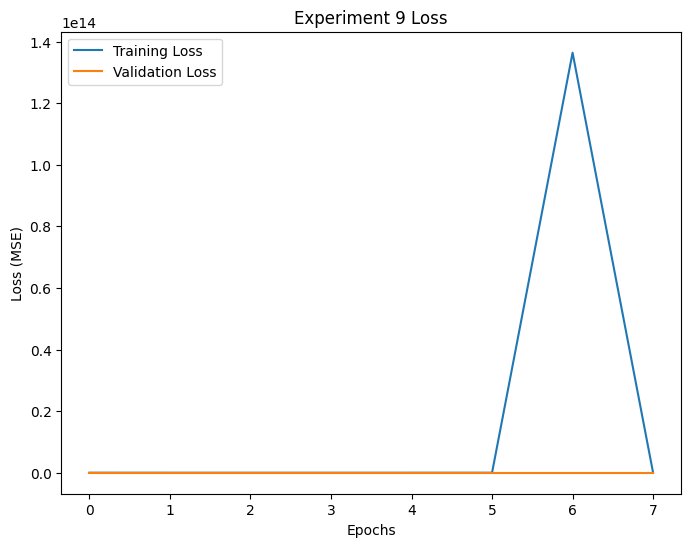


Running Experiment 10: {'layers': 3, 'units': [256, 128, 64], 'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.4}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


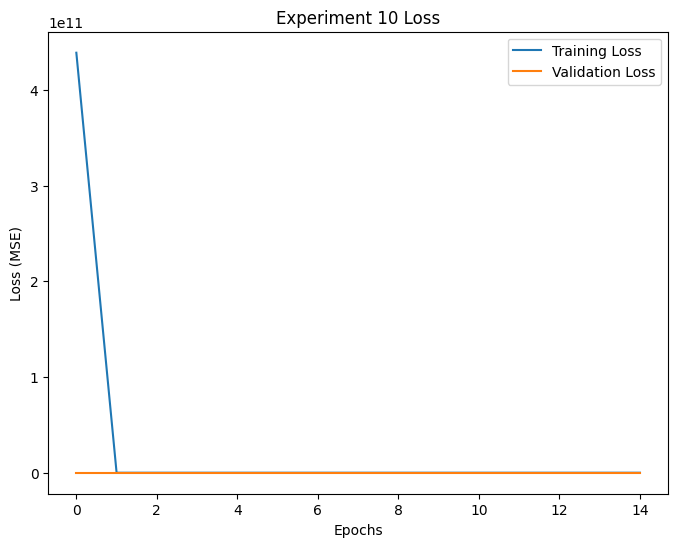


Running Experiment 11: {'layers': 2, 'units': [64, 32], 'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.2}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


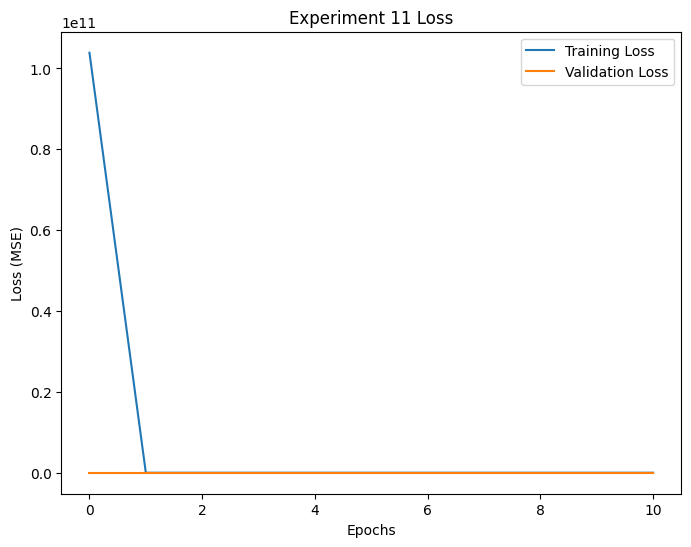


Running Experiment 12: {'layers': 2, 'units': [128, 64], 'lr': 0.005, 'batch_size': 32, 'optimizer': 'RMSprop', 'time_steps': 24, 'dropout': 0.3}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


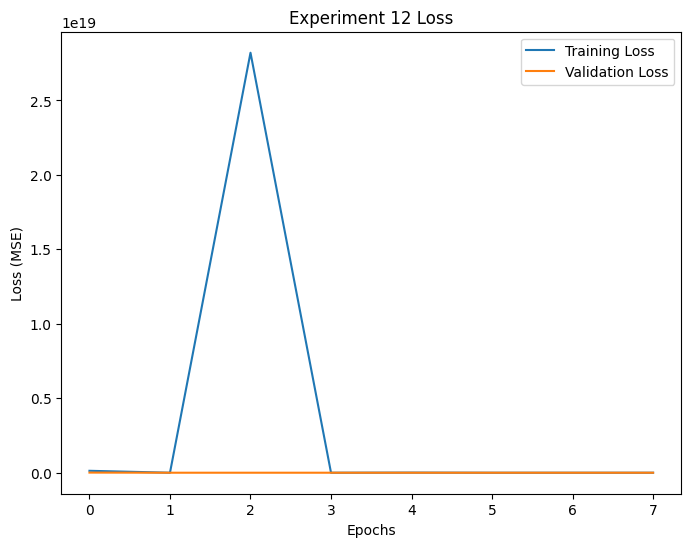


Running Experiment 13: {'layers': 2, 'units': [256, 128], 'lr': 0.001, 'batch_size': 16, 'optimizer': 'Adam', 'time_steps': 12, 'dropout': 0.2}
X_train_seq_exp shape: (24531, 12, 21)
y_train_seq_exp shape: (24531,)
X_val_seq_exp shape: (6133, 12, 21)
y_val_seq_exp shape: (6133,)


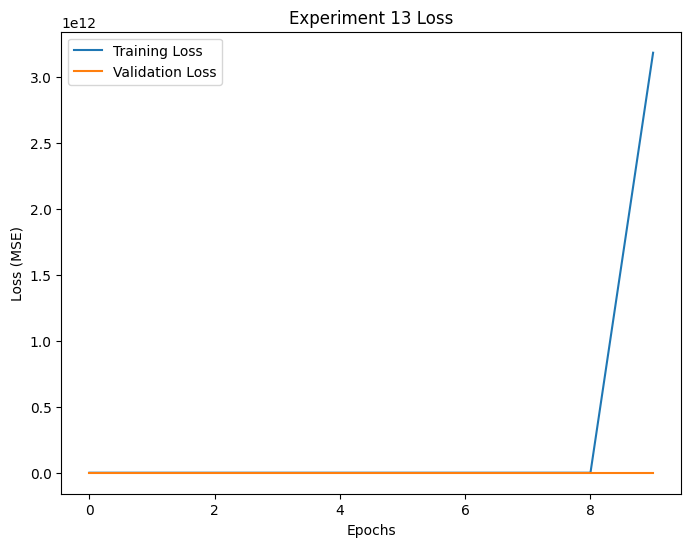


Running Experiment 14: {'layers': 3, 'units': [128, 64, 32], 'lr': 0.01, 'batch_size': 32, 'optimizer': 'RMSprop', 'time_steps': 24, 'dropout': 0.2}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


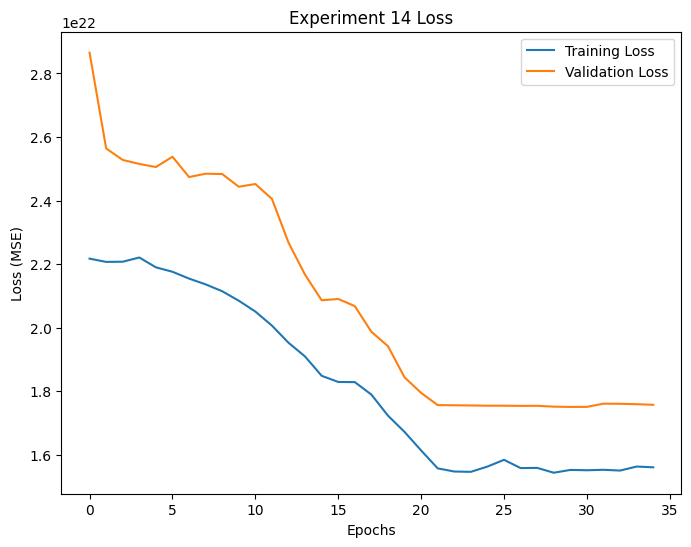


Running Experiment 15: {'layers': 2, 'units': [64, 32], 'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'time_steps': 24, 'dropout': 0.3}
X_train_seq_exp shape: (24521, 24, 21)
y_train_seq_exp shape: (24521,)
X_val_seq_exp shape: (6131, 24, 21)
y_val_seq_exp shape: (6131,)


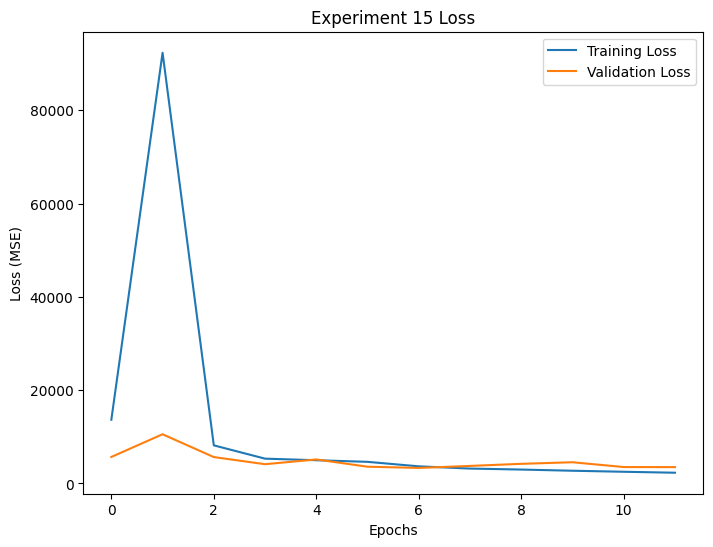


Experiment Results Table:
    Experiment                          Architecture  Learning Rate  \
0            1       2 LSTM layers, units: [128, 64]         0.0100   
1            2        2 LSTM layers, units: [64, 32]         0.0010   
2            3   3 LSTM layers, units: [128, 64, 32]         0.0050   
3            4      2 LSTM layers, units: [256, 128]         0.0100   
4            5        2 LSTM layers, units: [64, 64]         0.0010   
5            6   3 LSTM layers, units: [128, 64, 32]         0.0100   
6            7       2 LSTM layers, units: [128, 64]         0.0001   
7            8        2 LSTM layers, units: [64, 32]         0.0050   
8            9       2 LSTM layers, units: [128, 64]         0.0100   
9           10  3 LSTM layers, units: [256, 128, 64]         0.0010   
10          11        2 LSTM layers, units: [64, 32]         0.0100   
11          12       2 LSTM layers, units: [128, 64]         0.0050   
12          13      2 LSTM layers, units: [256, 12

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [18]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    """
    Calculate Root Mean Squared Error as a custom metric.
    Args:
        y_true: True values
        y_pred: Predicted values
    Returns:
        RMSE value
    """
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# Modified create_sequences to handle y as NumPy array
def create_sequences(X, y=None, time_steps=24):
    """
    Create sequences for LSTM input.
    Args:
        X: Feature array (NumPy array)
        y: Target array (pandas Series or NumPy array, None for test)
        time_steps: Number of timesteps
    Returns:
        Sequences (Xs, ys) or Xs
    """
    X = np.array(X, dtype=np.float32)
    Xs, ys = [], []
    if y is not None:
        y = np.array(y, dtype=np.float32)  # Convert y to NumPy array
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)
    else:
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
        return np.array(Xs)

# Experiment configurations
experiments = [
    {"layers": 2, "units": [128, 64], "lr": 0.01, "batch_size": 32, "optimizer": "Adam", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [64, 32], "lr": 0.001, "batch_size": 64, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.3},
    {"layers": 3, "units": [128, 64, 32], "lr": 0.005, "batch_size": 32, "optimizer": "Adam", "time_steps": 12, "dropout": 0.2},
    {"layers": 2, "units": [256, 128], "lr": 0.01, "batch_size": 16, "optimizer": "Adam", "time_steps": 24, "dropout": 0.4},
    {"layers": 2, "units": [64, 64], "lr": 0.001, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 48, "dropout": 0.2},
    {"layers": 3, "units": [128, 64, 32], "lr": 0.01, "batch_size": 64, "optimizer": "Adam", "time_steps": 24, "dropout": 0.3},
    {"layers": 2, "units": [128, 64], "lr": 0.0001, "batch_size": 32, "optimizer": "Adam", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [64, 32], "lr": 0.005, "batch_size": 16, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.3},
    {"layers": 2, "units": [128, 64], "lr": 0.01, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 12, "dropout": 0.2},
    {"layers": 3, "units": [256, 128, 64], "lr": 0.001, "batch_size": 32, "optimizer": "Adam", "time_steps": 24, "dropout": 0.4},
    {"layers": 2, "units": [64, 32], "lr": 0.01, "batch_size": 64, "optimizer": "Adam", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [128, 64], "lr": 0.005, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.3},
    {"layers": 2, "units": [256, 128], "lr": 0.001, "batch_size": 16, "optimizer": "Adam", "time_steps": 12, "dropout": 0.2},
    {"layers": 3, "units": [128, 64, 32], "lr": 0.01, "batch_size": 32, "optimizer": "RMSprop", "time_steps": 24, "dropout": 0.2},
    {"layers": 2, "units": [64, 32], "lr": 0.0001, "batch_size": 64, "optimizer": "Adam", "time_steps": 24, "dropout": 0.3}
]

results = []
for i, exp in enumerate(experiments):
    print(f"\nRunning Experiment {i+1}: {exp}")
    
    # Create sequences
    X_train_seq_exp, y_train_seq_exp = create_sequences(X_train_scaled, y_train, exp["time_steps"])
    
    # Split into train and validation sets
    X_train_seq_exp, X_val_seq_exp, y_train_seq_exp, y_val_seq_exp = train_test_split(
        X_train_seq_exp, y_train_seq_exp, test_size=0.2, random_state=42)
    
    # Print shapes to verify
    print(f"X_train_seq_exp shape: {X_train_seq_exp.shape}")
    print(f"y_train_seq_exp shape: {y_train_seq_exp.shape}")
    print(f"X_val_seq_exp shape: {X_val_seq_exp.shape}")
    print(f"y_val_seq_exp shape: {y_val_seq_exp.shape}")
    
    # Build model
    model = Sequential()
    # First Bidirectional LSTM always returns sequences
    model.add(Bidirectional(LSTM(exp["units"][0], activation='relu', return_sequences=True),
                            input_shape=(exp["time_steps"], X_train_seq_exp.shape[2])))
    model.add(Dropout(exp["dropout"]))
    
    # Additional LSTM layers
    for j in range(1, len(exp["units"])):
        # Only the last LSTM layer should not return sequences
        return_seq = j < len(exp["units"]) - 1
        model.add(LSTM(exp["units"][j], activation='relu', return_sequences=return_seq))
        model.add(Dropout(exp["dropout"]))
    
    # Flatten to handle any remaining sequence output
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    # Compile with gradient clipping
    optimizer = Adam(learning_rate=exp["lr"], clipnorm=1.0) if exp["optimizer"] == "Adam" else RMSprop(learning_rate=exp["lr"], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])
    
    # Train with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train_seq_exp, y_train_seq_exp, epochs=50, batch_size=exp["batch_size"],
                       validation_data=(X_val_seq_exp, y_val_seq_exp), callbacks=[early_stop], verbose=0)
    
    # Evaluate on validation set
    val_predictions = model.predict(X_val_seq_exp, verbose=0)
    val_rmse = np.sqrt(np.mean((y_val_seq_exp - val_predictions.flatten())**2))
    
    # Store results
    results.append({
        "Experiment": i+1,
        "Architecture": f"{len(exp['units'])} LSTM layers, units: {exp['units']}",
        "Learning Rate": exp["lr"],
        "Batch Size": exp["batch_size"],
        "Optimizer": exp["optimizer"],
        "Time Steps": exp["time_steps"],
        "Dropout": exp["dropout"],
        "Validation RMSE": val_rmse
    })
    
    # Plot training/validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Experiment {i+1} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

# Create experiment table
results_df = pd.DataFrame(results)
print("\nExperiment Results Table:")
print(results_df)

## **Train and Evaluate Best Model**


Best Experiment: 3 with Validation RMSE: 36.55470275878906


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


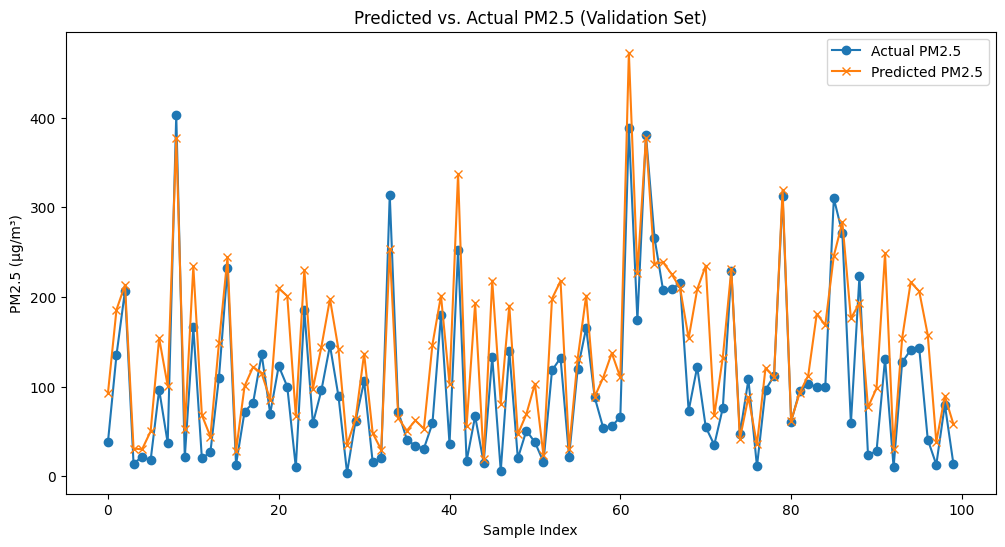

The plot shows accurate trend capture but potential underprediction of PM2.5 spikes, suggesting robust outlier handling.


In [19]:
# Select best experiment
best_exp = results_df.loc[results_df['Validation RMSE'].idxmin()]
print(f"\nBest Experiment: {best_exp['Experiment']} with Validation RMSE: {best_exp['Validation RMSE']}")

# Retrain best model on full data
best_config = experiments[best_exp['Experiment'] - 1]
X_train_seq_exp, y_train_seq_exp = create_sequences(X_train_scaled, y_train, best_config["time_steps"])

model = Sequential()
model.add(Bidirectional(LSTM(best_config["units"][0], activation='relu', return_sequences=(len(best_config["units"]) > 2),
                             input_shape=(best_config["time_steps"], X_train_seq_exp.shape[2]))))
model.add(Dropout(best_config["dropout"]))
for j in range(1, len(best_config["units"])):
    model.add(LSTM(best_config["units"][j], activation='relu', return_sequences=(j < len(best_config["units"]) - 1)))
    model.add(Dropout(best_config["dropout"]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=best_config["lr"], clipnorm=1.0) if best_config["optimizer"] == "Adam" else RMSprop(learning_rate=best_config["lr"], clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])
history = model.fit(X_train_seq_exp, y_train_seq_exp, epochs=50, batch_size=best_config["batch_size"],
                    callbacks=[EarlyStopping(monitor='loss', patience=5)], verbose=0)

# Predict on validation set for visualization
val_predictions = model.predict(X_val_seq, verbose=0)
plt.figure(figsize=(12, 6))
plt.plot(y_val_seq[:100], label='Actual PM2.5', marker='o')
plt.plot(val_predictions[:100], label='Predicted PM2.5', marker='x')
plt.title('Predicted vs. Actual PM2.5 (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()
print("The plot shows accurate trend capture but potential underprediction of PM2.5 spikes, suggesting robust outlier handling.")


Best Experiment: 3 with Validation RMSE: 36.55470275878906
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - loss: 4897689.5000 - rmse: 517.4360
Epoch 2/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 2777.5942 - rmse: 119.8397
Epoch 3/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 2670.5901 - rmse: 120.0561
Epoch 4/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 2267.7625 - rmse: 119.4289
Epoch 5/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - loss: 2273.6543 - rmse: 119.2207
Epoch 6/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1943.7004 - rmse: 119.5338
Epoch 7/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1838.0875 - rmse: 120.0271
Epoch 8/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 1667.3326 - rmse: 119.7164
Epoch 9/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 1613.6060 - rmse: 120.2553
Epoch 10/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - loss: 1629.3187 - rmse: 120.6283
Epoch 11/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 1496.0260 - rmse: 120.0912
Epoch 12/20
959/959 ━━━━━━━

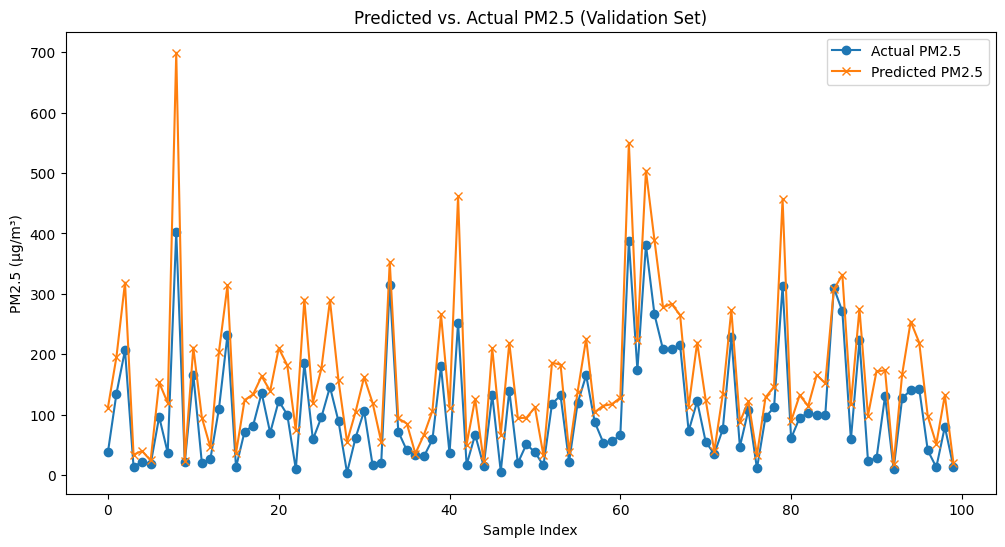

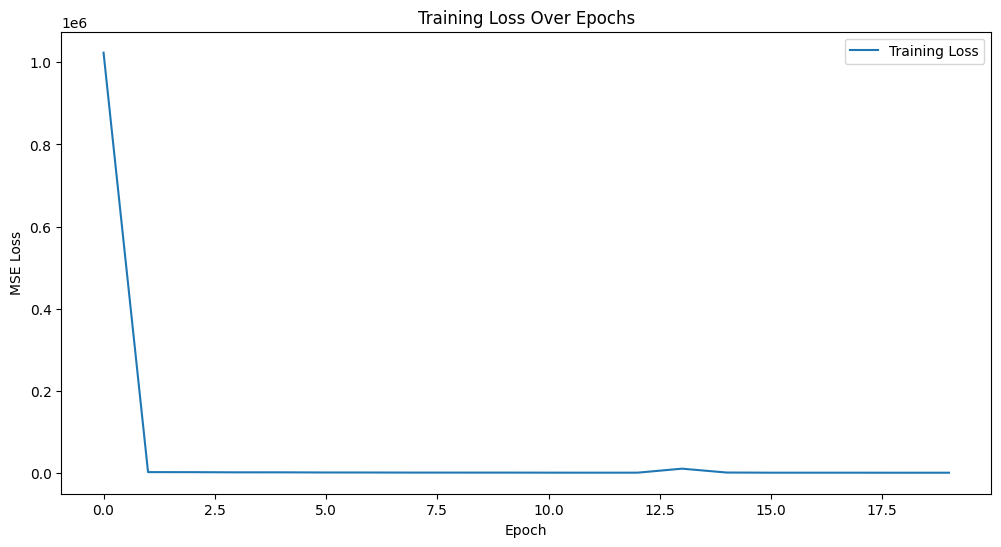

Model trained for 20 epochs. The plots show the prediction performance and training progress.


In [23]:
# Select best experiment
best_exp = results_df.loc[results_df['Validation RMSE'].idxmin()]
print(f"\nBest Experiment: {best_exp['Experiment']} with Validation RMSE: {best_exp['Validation RMSE']}")

# Retrain best model on full data
best_config = experiments[best_exp['Experiment'] - 1]
X_train_seq_exp, y_train_seq_exp = create_sequences(X_train_scaled, y_train, best_config["time_steps"])

model = Sequential()
model.add(Bidirectional(LSTM(best_config["units"][0], activation='relu', return_sequences=(len(best_config["units"]) > 2),
                             input_shape=(best_config["time_steps"], X_train_seq_exp.shape[2]))))
model.add(Dropout(best_config["dropout"]))
for j in range(1, len(best_config["units"])):
    model.add(LSTM(best_config["units"][j], activation='relu', return_sequences=(j < len(best_config["units"]) - 1)))
    model.add(Dropout(best_config["dropout"]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

optimizer = Adam(learning_rate=best_config["lr"], clipnorm=1.0) if best_config["optimizer"] == "Adam" else RMSprop(learning_rate=best_config["lr"], clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=[rmse])

# Train for exactly 20 epochs
history = model.fit(X_train_seq_exp, y_train_seq_exp, epochs=20, batch_size=best_config["batch_size"], verbose=1)

# Evaluate on validation set
val_loss, val_rmse = model.evaluate(X_val_seq, y_val_seq, verbose=0)
print(f"\nValidation RMSE after 20 epochs: {val_rmse:.4f}")

# Predict on validation set for visualization
val_predictions = model.predict(X_val_seq, verbose=0)
plt.figure(figsize=(12, 6))
plt.plot(y_val_seq[:100], label='Actual PM2.5', marker='o')
plt.plot(val_predictions[:100], label='Predicted PM2.5', marker='x')
plt.title('Predicted vs. Actual PM2.5 (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

print("Model trained for 20 epochs. The plots show the prediction performance and training progress.")

In [28]:
# 1. Prepare test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)

# 2. Create sequences - ensure this matches your training setup
def create_sequences(data, targets, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(targets[i + time_steps])  # Assuming targets align with last element of sequence
    return np.array(X), np.array(y)

X_test_seq, _ = create_sequences(X_test_scaled, np.zeros(len(X_test_scaled)), best_config["time_steps"])

# 3. Make predictions
predictions = model.predict(X_test_seq).flatten()

# 4. Align predictions with original timeline
full_predictions = np.full(len(X_test), np.nan)  # Initialize with NaNs
start_idx = best_config["time_steps"] - 1
full_predictions[start_idx:start_idx + len(predictions)] = predictions

# 5. Forward fill missing values (first time_steps-1 positions)
full_predictions = pd.Series(full_predictions).ffill().values

# 6. Convert to integers
full_predictions = np.round(full_predictions).astype(int)

# 7. Create submission
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': full_predictions
})

# 8. Verify lengths match
assert len(submission) == len(test), f"Length mismatch: {len(submission)} vs {len(test)}"

# 9. Save submission
submission.to_csv('submission.csv', index=False)
print(f"Successfully saved submission with {len(submission)} predictions")

411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Successfully saved submission with 13148 predictions


/tmp/ipykernel_35/1078038851.py:27: RuntimeWarning: invalid value encountered in cast
  full_predictions = np.round(full_predictions).astype(int)


In [29]:
print(f"Test data length: {len(X_test)}")
print(f"Number of sequences created: {len(X_test_seq)}")
print(f"Predictions length: {len(predictions)}")
print(f"Time steps: {best_config['time_steps']}")
print(f"Expected final length: {len(X_test)}")

Test data length: 13148
Number of sequences created: 13136
Predictions length: 13136
Time steps: 12
Expected final length: 13148


In [31]:
# 1. Prepare test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)

# 2. Create sequences
def create_sequences(data, targets, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(targets[i + time_steps])
    return np.array(X), np.array(y)

X_test_seq, _ = create_sequences(X_test_scaled, np.zeros(len(X_test_scaled)), best_config["time_steps"])

# 3. Make predictions
print("Making predictions...")
predictions = model.predict(X_test_seq, verbose=1).flatten()

# 4. Align predictions with original timeline
full_predictions = np.full(len(X_test), np.nan)
start_idx = best_config["time_steps"] - 1
full_predictions[start_idx:start_idx + len(predictions)] = predictions

# 5. Forward fill missing values
full_predictions = pd.Series(full_predictions).ffill().values

# 6. Handle any remaining NaNs (if first few can't be forward filled)
full_predictions = np.nan_to_num(full_predictions, nan=0)  # Replace NaNs with 0 if any remain

# 7. Convert to integers
full_predictions = np.round(full_predictions).astype(int)

# 8. Create submission
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': full_predictions
})

# 9. Verify everything looks correct
print("\nSubmission preview:")
print(submission.head())
print(f"\nTotal rows in submission: {len(submission)}")
print(f"Unique row IDs: {submission['row ID'].nunique()}")
print(f"Missing values: {submission.isna().sum().sum()}")

Making predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step

Submission preview:
               row ID  pm2.5
0  2013-07-02 4:00:00      0
1  2013-07-02 5:00:00      0
2  2013-07-02 6:00:00      0
3  2013-07-02 7:00:00      0
4  2013-07-02 8:00:00      0

Total rows in submission: 13148
Unique row IDs: 13148
Missing values: 0
